# **1CK130: Assignment 4**

*Lecturers: dr. Bram De Moor, dr. Mirjam Meijer, Emre Kara Msc.*

---

Velocation, the bike-rental operator based in Paris, was very satisfied with the work you completed in the previous assignments. As a result, they have once again requested your assistance to help optimize their logistics network of 48 bike rental stations. Unlike the earlier assignments, this one introduces a multi-period setting: the distribution of bikes across all rental stations at the end of each day becomes the starting distribution for the following day. By designing an efficient nightly rebalancing strategy, you will aim to optimize the overall performance of Velocation’s bike-sharing network. To support this analysis, you are provided with data, described below, that is similar to Assignment 3.


## Data

Like in Assignment 3, you have access to the following data: `bike_locations_data.xlsx` and `transactions_data.xlsx`. `bike_locations_data.xlsx` contains the location in x- and y-coordinates of 48 bike rental stations. `transactions_data.xlsx` contains data on bike withdrawals and returns for six representative days. Per transaction (a row in `transactions_data.xlsx`), the following data is provided in columns:
* `oper_day`: an id (between 0 and 5) that connects to the day for which this data was collected. The data contains all trips that were started between 00:00 and 23:59 on the respective days.
* `wdr_loc`: location where the bike was picked up.
* `wdr_b`: number of bikes at the withdrawal location, just after this bike was withdrawn.
* `wdr_t`: time at which the bike was withdrawn (number representing the amount of hours after 00:00. I.e. 6.5 refers to six and a half hours after midnight, i.e. 06:30AM.)
* `ret_loc`: location where the bike was returned.
* `ret_b`: number of bikes at the return location, just after this bike was returned.
* `ret_t`: time at which bike was returned (same encoding as `wdr_t`).

You are encouraged to build upon the data analysis performed in Assignment 3 to conduct the analyses for this assignment. To load the data, you need to correctly mount the drive, similar to Assignment 3:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


After successfully mounting the drive, the code below loads the data as dataframes. Note that you may need to change `file_path` depending on where in Google Drive you stored the excel file.

In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/1CK130/2025/Assignments/Data/'
locations_data = pd.read_excel(file_path + 'bike_locations_data.xlsx')
transactions_data = pd.read_excel(file_path + 'transactions_data.xlsx')

In [8]:
#### This is how i loaded the data above is how teacher wants us to do
import pandas as pd
import os

file_path = r"C:\Users\OneDrive\Υπολογιστής\Magdaskkkrtt\Math for AI\pyhton\magda_is_demon_hunter_correct\data_assignment_4"

locations_data = pd.read_excel(os.path.join(file_path, "bike_locations_data.xlsx"))
transactions_data = pd.read_excel(os.path.join(file_path, "transactions_data.xlsx"))


## PART I: Evaluating the network's imbalance

Before optimizing Velocation’s rebalancing operations, it is essential to first determine whether rebalancing is actually needed. To do so, analyze how the distribution of bikes across stations evolves over time when there is no nightly rebalancing and compute the average service level of the network, defined as: 1 - (customers turned away / total customers).
Assume there is a total of 1248 bikes, initially distributed equally among all stations (so each station has 26 bikes). Ensure that your analysis is statistically rigorous and supported by clear, insightful visualizations. You are encouraged to use and adapt code from the previous assignments.

We need to answer the following question : If we do NOT rebalance bikes overnight, does the system naturally become imbalanced and does this imbalance significantly reduce service level?

We have 48 station each having 26 bikes.
Our key performance metric will be same as in assignment 3, service level.

We need to import the following code from assignment 3 :



### Importing code from Assignment 3

In [9]:
import math
df = locations_data

class Location:
    def __init__(self, loc, x, y):
        self.loc = loc
        self.x = x
        self.y = y


    def distance(self, other):
        return math.sqrt((self.x - other.x) ** 2 + (self.y - other.y) ** 2)
    def __repr__(self):
        return f"loc{self.loc}(x={self.x}, y={self.y})"
#this loads the data into the locations list
locations = [Location(loc=int(row['loc']), x=row['x'], y=row['y']) for _, row in df.iterrows()]


In [11]:
data = transactions_data

# Group by operating_day_id
grouped_data = data.groupby('oper_day')

# Store data for each day
daily_data = {day: group.drop(columns='oper_day') for day, group in grouped_data}

# Display sample
for day in daily_data:
    print(f"Data for Day {day} (first 5 rows):")
    print(daily_data[day].head(), "\n")


Data for Day 0 (first 5 rows):
   wdr_loc  wdr_b     wdr_t  ret_loc  ret_b     ret_t
0        8     35  5.024877        5     27  6.167177
1        5     25  5.078680       14     42  5.543884
2       29     26  5.080032        8     31  6.407872
3        4     26  5.097119       25     14  5.543075
4       34     16  5.103508       23     22  6.111822 

Data for Day 1 (first 5 rows):
      wdr_loc  wdr_b     wdr_t  ret_loc  ret_b     ret_t
8370       32     22  5.034253       13     21  6.193552
8371        4     22  5.037247       17     26  5.890561
8372       29     19  5.142344       13     21  5.946445
8373       17     25  5.157454       13     22  6.453905
8374       20     13  5.280598       21     29  5.590164 

Data for Day 2 (first 5 rows):
       wdr_loc  wdr_b     wdr_t  ret_loc  ret_b     ret_t
15989        2     34  5.007197        9     40  5.229195
15990       15     20  5.007871       15     21  5.204072
15991       26     11  5.008282        5     24  5.503213
15992

First we will import from Assignment 3 the code for estimating when during the day customers arrive at each station.
The variabe we need from this code is loc_percentages, which represents the hourly demand probabilities per station

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Configuration
NUM_LOCATIONS = 48
HOURS_IN_DAY = 24
NUM_DAYS = 6

# ========== STEP 1: Initialize data structure ==========
# Create nested dictionary to store withdrawal counts per hour
# Structure: loc_dict_wdr['Location 0']['8 - 9'] = number of withdrawals
loc_dict_wdr = {
    f'Location {i}': {f'{h} - {h+1}': 0 for h in range(HOURS_IN_DAY)}
    for i in range(NUM_LOCATIONS)
}

# ========== STEP 2: Count withdrawals per location per hour ==========
for day in range(NUM_DAYS):
    day_data = daily_data[day]

    for row in day_data.itertuples():
        if pd.notna(row.wdr_loc):
            loc_id = int(row.wdr_loc)

            if 0 <= loc_id < NUM_LOCATIONS:
                loc_key = f'Location {loc_id}'
                hour_int = int(row.wdr_t)  # Extract hour (e.g., 8.5 becomes 8)
                if hour_int >= 24: hour_int = 23  # Handle edge case
                time_bin = f'{hour_int} - {hour_int + 1}'
                loc_dict_wdr[loc_key][time_bin] += 1

# ========== STEP 3: Calculate average over 6 days ==========
for loc in loc_dict_wdr:
    for time_bin in loc_dict_wdr[loc]:
        loc_dict_wdr[loc][time_bin] /= NUM_DAYS

# ========== STEP 4: Convert counts to percentages ==========
# This normalizes demand patterns so we can compare locations
loc_percentages = {}
for loc, hourly_counts in loc_dict_wdr.items():
    total = sum(hourly_counts.values())  # Total daily withdrawals

    if total > 0:
        # Convert each hour's count to percentage of daily total
        loc_percentages[loc] = {
            time_bin: count / total
            for time_bin, count in hourly_counts.items()
        }
    else:
        loc_percentages[loc] = {time_bin: 0 for time_bin in hourly_counts}


In [28]:
print(loc_percentages)

{'Location 0': {'0 - 1': 0.0, '1 - 2': 0.0, '2 - 3': 0.0, '3 - 4': 0.0, '4 - 5': 0.0, '5 - 6': 0.00273224043715847, '6 - 7': 0.030737704918032786, '7 - 8': 0.07581967213114754, '8 - 9': 0.1325136612021858, '9 - 10': 0.056010928961748634, '10 - 11': 0.041666666666666664, '11 - 12': 0.06215846994535519, '12 - 13': 0.05806010928961748, '13 - 14': 0.0430327868852459, '14 - 15': 0.0744535519125683, '15 - 16': 0.09221311475409837, '16 - 17': 0.10655737704918032, '17 - 18': 0.06147540983606557, '18 - 19': 0.06079234972677596, '19 - 20': 0.050546448087431695, '20 - 21': 0.02459016393442623, '21 - 22': 0.011612021857923498, '22 - 23': 0.015027322404371584, '23 - 24': 0.0}, 'Location 1': {'0 - 1': 0.0, '1 - 2': 0.0, '2 - 3': 0.0, '3 - 4': 0.0, '4 - 5': 0.0, '5 - 6': 0.0007199424046076314, '6 - 7': 0.027357811375089993, '7 - 8': 0.0964722822174226, '8 - 9': 0.11375089992800576, '9 - 10': 0.04103671706263499, '10 - 11': 0.054715622750179986, '11 - 12': 0.09719222462203024, '12 - 13': 0.06191504679

Then we will import the code which reconstructs the real daily demand per station by imputing lost demand during stockouts.
The variable avg_real_demand is the most important variable returned, which gives us the real demand

In [19]:
# ========== STEP 1: Initialize data structures ==========
real_demand_totals = {i: 0.0 for i in range(NUM_LOCATIONS)}
hourly_stats = {}  # Will store: hourly_stats[loc][day][hour] = {'obs': count, 'avail_min': minutes}

# ========== STEP 2: Identify stockouts and calculate available time ==========
for loc_id in range(NUM_LOCATIONS):
    hourly_stats[loc_id] = {}

    for day in range(NUM_DAYS):
        # Initialize: assume full 60 minutes available per hour
        hourly_stats[loc_id][day] = {h: {'obs': 0, 'avail_min': 60.0} for h in range(HOURS_IN_DAY)}

        day_data = daily_data[day]

        # --- Extract withdrawal and return events ---
        wdrs = day_data[day_data['wdr_loc'] == loc_id][['wdr_t', 'wdr_b']].copy()
        wdrs['type'] = 'wdr'
        wdrs.rename(columns={'wdr_t': 'time', 'wdr_b': 'stock'}, inplace=True)

        rets = day_data[day_data['ret_loc'] == loc_id][['ret_t', 'ret_b']].copy()
        rets['type'] = 'ret'
        rets.rename(columns={'ret_t': 'time', 'ret_b': 'stock'}, inplace=True)

        # Merge and sort events by time (chronological order)
        events = pd.concat([wdrs, rets]).sort_values('time')

        # --- Find stockout periods ---
        # A stockout starts when a withdrawal leaves 0 bikes, ends when a bike is returned
        stockouts = []
        on_stockout = False
        start_time = 0.0

        for row in events.itertuples():
            # Stockout begins
            if row.type == 'wdr' and row.stock == 0 and not on_stockout:
                on_stockout = True
                start_time = row.time
            # Stockout ends
            elif row.type == 'ret' and on_stockout:
                on_stockout = False
                stockouts.append((start_time, row.time))

        # If still in stockout at end of day
        if on_stockout:
            stockouts.append((start_time, 24.0))

        # --- Calculate available time per hour ---
        for h in range(HOURS_IN_DAY):
            t_start = float(h)
            t_end = float(h + 1)

            # Find overlap between stockout periods and this hour
            unavailable = 0.0
            for s_start, s_end in stockouts:
                ov_start = max(s_start, t_start)  # Later of the two starts
                ov_end = min(s_end, t_end)        # Earlier of the two ends
                if ov_end > ov_start:
                    unavailable += (ov_end - ov_start)

            # Convert to minutes
            avail_min = (1.0 - unavailable) * 60.0
            hourly_stats[loc_id][day][h]['avail_min'] = max(0.0, avail_min)

            # Count observed withdrawals in this hour
            obs = len(wdrs[(wdrs['time'] >= t_start) & (wdrs['time'] < t_end)])
            hourly_stats[loc_id][day][h]['obs'] = obs

# ========== STEP 3: Calculate demand rates and impute lost demand ==========
for loc_id in range(NUM_LOCATIONS):
    for h in range(HOURS_IN_DAY):
        # --- Calculate average rate for this location/hour ---
        total_obs = 0
        total_avail_min = 0.0

        for day in range(NUM_DAYS):
            stats = hourly_stats[loc_id][day][h]
            total_obs += stats['obs']
            total_avail_min += stats['avail_min']

        # Compute rate (withdrawals per minute)
        if total_avail_min > 5:  # Need sufficient data
            rate = total_obs / total_avail_min
        else:
            rate = 0.0

        # --- Apply rate to estimate lost demand ---
        for day in range(NUM_DAYS):
            stats = hourly_stats[loc_id][day][h]
            obs = stats['obs']                      # Observed withdrawals
            lost_min = 60.0 - stats['avail_min']   # Minutes unavailable
            lost_demand = rate * lost_min           # Estimated lost demand

            # Real demand = observed + estimated lost
            real_demand_totals[loc_id] += (obs + lost_demand)

# ========== STEP 4: Calculate average daily real demand ==========
print("Estimated Real Daily Demand per Location:")
avg_real_demand = {}
for loc_id in range(NUM_LOCATIONS):
    avg = real_demand_totals[loc_id] / NUM_DAYS
    avg_real_demand[loc_id] = avg
    print(f"Location {loc_id}: {avg:.2f}")



Estimated Real Daily Demand per Location:
Location 0: 249.37
Location 1: 238.56
Location 2: 241.01
Location 3: 255.89
Location 4: 250.67
Location 5: 256.09
Location 6: 264.38
Location 7: 238.40
Location 8: 250.38
Location 9: 251.33
Location 10: 247.72
Location 11: 260.37
Location 12: 224.36
Location 13: 201.89
Location 14: 202.39
Location 15: 131.55
Location 16: 134.89
Location 17: 132.83
Location 18: 145.71
Location 19: 139.48
Location 20: 137.92
Location 21: 150.17
Location 22: 130.95
Location 23: 136.80
Location 24: 135.16
Location 25: 135.92
Location 26: 146.05
Location 27: 147.27
Location 28: 136.17
Location 29: 146.00
Location 30: 135.05
Location 31: 137.20
Location 32: 141.88
Location 33: 140.01
Location 34: 135.36
Location 35: 142.89
Location 36: 136.27
Location 37: 131.10
Location 38: 155.01
Location 39: 141.23
Location 40: 141.31
Location 41: 138.36
Location 42: 126.01
Location 43: 128.84
Location 44: 138.03
Location 45: 134.02
Location 46: 519.39
Location 47: 530.08


In [29]:
print(avg_real_demand)
# We will be using this to calculate the service level for rebalancing

{0: 249.3685244204149, 1: 238.55837992527486, 2: 241.00554068514626, 3: 255.89404386133506, 4: 250.66666666666666, 5: 256.08735008561183, 6: 264.38202531610904, 7: 238.40095673598867, 8: 250.38280699442427, 9: 251.3283778271011, 10: 247.7197407508257, 11: 260.37129008000784, 12: 224.3562201798835, 13: 201.88733649476555, 14: 202.3923961303427, 15: 131.55456955429725, 16: 134.88794378032765, 17: 132.82628935412825, 18: 145.70755076474094, 19: 139.4763184705505, 20: 137.91770771236335, 21: 150.16661991455945, 22: 130.9532717827184, 23: 136.79879116491568, 24: 135.15861332332156, 25: 135.91971378321483, 26: 146.04977724621926, 27: 147.26888783554546, 28: 136.1662832670726, 29: 146.00365080487026, 30: 135.04677129147078, 31: 137.2007018469581, 32: 141.88371635393509, 33: 140.01318340740656, 34: 135.3583860233239, 35: 142.88511000585618, 36: 136.26633661687683, 37: 131.0993812707819, 38: 155.01080909239062, 39: 141.23032317279942, 40: 141.31434983241408, 41: 138.3600868604215, 42: 126.01490

Then we will use the code to simulate  when customers arrive at a specific station during one day, based on:

How many customers want to rent there per day (avg_real_demand)
How demand is distributed over the day (loc_percentages)

It generates a list of attempted customer arrival times at a station using a Poisson process.
The needed variabe is the arrivals returned by the function that will be used for simulation

In [20]:
import numpy as np

def generate_customer_arrivals(location_id, avg_real_demand, loc_percentages):
    """
    Generate customer arrival times for a single location for one day using a Poisson process.

    Args:
        location_id: Location ID (0-47)
        avg_real_demand: Dict with average daily demand per location
        loc_percentages: Dict with hourly percentages per location

    Returns:
        List of arrival times (in hours from 00:00)
    """
    arrivals = []
    loc_key = f'Location {location_id}'
    daily_demand = avg_real_demand[location_id]
    hourly_pcts = loc_percentages[loc_key]

    # ========== Generate arrivals for each hour ==========
    for hour in range(24):
        time_bin = f'{hour} - {hour+1}'
        pct = hourly_pcts[time_bin]
        hourly_rate = daily_demand * pct  # Expected customers this hour

        if hourly_rate <= 0:
            continue

        # --- Generate Poisson arrivals using exponential inter-arrival times ---
        rate_per_minute = hourly_rate / 60.0  # Convert hourly to per-minute rate
        current_time = float(hour)            # Start at beginning of hour

        # Keep generating arrivals until we exceed the hour boundary
        while current_time < hour + 1:
            # Sample next inter-arrival time from exponential distribution
            inter_arrival = np.random.exponential(1.0 / rate_per_minute) / 60.0
            current_time += inter_arrival

            # Only add if still within this hour
            if current_time < hour + 1:
                arrivals.append(current_time)

    return arrivals



Then we will import the code that learns where bikes go after they are rented. The important variable returned is dest_prob which gives us the conditional probability distribution of each station.
Meaning:
If a bike is rented at station X, there is an MN% chance it is returned to station K

In [21]:
# ========== STEP 1: Initialize destination probability matrix ==========
# Create 48x48 matrix: dest_prob[origin][destination] = probability
dest_prob = {i: {j: 0 for j in range(NUM_LOCATIONS)} for i in range(NUM_LOCATIONS)}

# ========== STEP 2: Count trips from each origin to each destination ==========
for day in range(NUM_DAYS):
    day_data = daily_data[day]

    for row in day_data.itertuples():
        if pd.notna(row.wdr_loc) and pd.notna(row.ret_loc):
            origin = int(row.wdr_loc)
            destination = int(row.ret_loc)

            if 0 <= origin < NUM_LOCATIONS and 0 <= destination < NUM_LOCATIONS:
                dest_prob[origin][destination] += 1  # Count this O-D pair

# ========== STEP 3: Normalize to get probabilities ==========
# For each origin, divide by total trips to get probability distribution
for origin in range(NUM_LOCATIONS):
    total_trips = sum(dest_prob[origin].values())

    if total_trips > 0:
        # Convert counts to probabilities (sum will equal 1.0)
        for destination in range(NUM_LOCATIONS):
            dest_prob[origin][destination] /= total_trips
    else:
        # Uniform distribution if no data available
        for destination in range(NUM_LOCATIONS):
            dest_prob[origin][destination] = 1.0 / NUM_LOCATIONS


Last code we will be importing from Assignment 3 is the one below, that estimates how long bikes are unavailable after being rented, depending on:

Where they are taken from (origin)

Where they are returned (destination)

How far those stations are apart

The most important output is travel times, which gives us the O–D travel-time distributions

Total valid trips analyzed: 49359
Distance range: 0.00 to 18.25
Travel time range: 0.00 to 5.47 hours

Linear Model: travel_time = 0.2672 + 0.0711 × distance
Implied speed: 14.06 distance units per hour


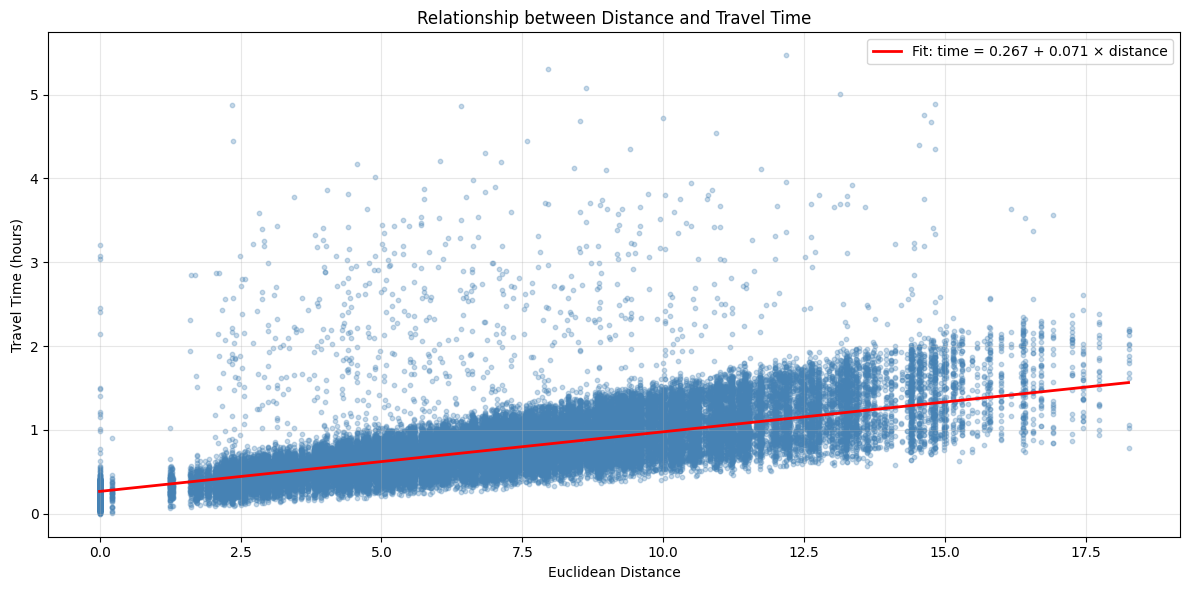

C:\Users\irene\AppData\Local\Temp\ipykernel_21100\2676002383.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_clean['predicted_time'] = a + b * trips_clean['distance']
C:\Users\irene\AppData\Local\Temp\ipykernel_21100\2676002383.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_clean['residual'] = trips_clean['travel_time'] - trips_clean['predicted_time']


Residual standard deviation: 0.1942 hours

Sample Travel Time Estimates (Origin → Destination)

Location 0 → Location 5:
  Distance: 4.54
  Mean travel time: 0.64 hours (38.5 minutes)
  Std deviation: 0.41 hours
  Data source: empirical (45 observations)

Location 0 → Location 20:
  Distance: 6.03
  Mean travel time: 0.68 hours (40.9 minutes)
  Std deviation: 0.19 hours
  Data source: empirical (28 observations)

Location 10 → Location 30:
  Distance: 11.64
  Mean travel time: 1.11 hours (66.4 minutes)
  Std deviation: 0.27 hours
  Data source: empirical (19 observations)

Location 15 → Location 15:
  Distance: 0.00
  Mean travel time: 0.24 hours (14.1 minutes)
  Std deviation: 0.09 hours
  Data source: empirical (26 observations)

Location 20 → Location 40:
  Distance: 3.20
  Mean travel time: 0.50 hours (30.1 minutes)
  Std deviation: 0.12 hours
  Data source: empirical (14 observations)

2233 O-D pairs have observed data
71 pairs use model-based estimates


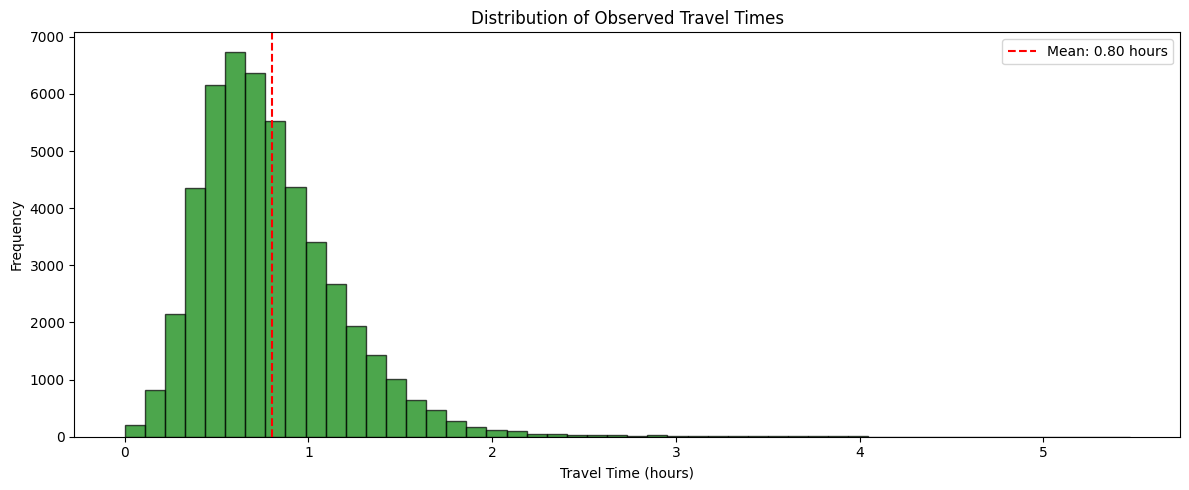


Usage in Simulation:
Sample travel time: travel_time = np.random.normal(mean, std)
Ensure positive: travel_time = max(travel_time, 0.01)


In [16]:
# STEP 1: Extract trip data with travel times and distances
trip_data = []

for day in range(NUM_DAYS):
    day_data = daily_data[day]

    for row in day_data.itertuples():
        if pd.notna(row.wdr_loc) and pd.notna(row.ret_loc):
            origin = int(row.wdr_loc)
            destination = int(row.ret_loc)

            if 0 <= origin < NUM_LOCATIONS and 0 <= destination < NUM_LOCATIONS:
                # Calculate travel time (return time - withdrawal time)
                travel_time = row.ret_t - row.wdr_t

                # Only include same-day trips (0 < time < 24 hours)
                if 0 < travel_time < 24:
                    # Calculate Euclidean distance using Location class
                    distance = locations[origin].distance(locations[destination])

                    trip_data.append({
                        'origin': origin,
                        'destination': destination,
                        'travel_time': travel_time,
                        'distance': distance
                    })

trips_df = pd.DataFrame(trip_data)

print(f"Total valid trips analyzed: {len(trips_df)}")
print(f"Distance range: {trips_df['distance'].min():.2f} to {trips_df['distance'].max():.2f}")
print(f"Travel time range: {trips_df['travel_time'].min():.2f} to {trips_df['travel_time'].max():.2f} hours")

#  STEP 2: Visualize distance vs travel time relationship
plt.figure(figsize=(12, 6))
plt.scatter(trips_df['distance'], trips_df['travel_time'],
            alpha=0.3, s=10, color='steelblue')
plt.xlabel('Euclidean Distance')
plt.ylabel('Travel Time (hours)')
plt.title('Relationship between Distance and Travel Time')
plt.grid(True, alpha=0.3)

# STEP 3: Fit linear regression model
from numpy.polynomial import Polynomial

# Remove outliers (top 5% of travel times)
trips_clean = trips_df[trips_df['travel_time'] < trips_df['travel_time'].quantile(0.95)]

# Fit model: travel_time = a + b × distance
p = Polynomial.fit(trips_clean['distance'], trips_clean['travel_time'], deg=1)
a, b = p.convert().coef  # a = intercept, b = slope

print(f"\nLinear Model: travel_time = {a:.4f} + {b:.4f} × distance")
if b > 0:
    print(f"Implied speed: {1/b:.2f} distance units per hour")

# Plot regression line
distances_plot = np.linspace(0, trips_df['distance'].max(), 100)
times_plot = a + b * distances_plot
plt.plot(distances_plot, times_plot, 'r-', linewidth=2,
         label=f'Fit: time = {a:.3f} + {b:.3f} × distance')
plt.legend()
plt.tight_layout()
plt.show()

# STEP 4: Calculate residual standard deviation
# This measures how much actual times vary from predictions
trips_clean['predicted_time'] = a + b * trips_clean['distance']
trips_clean['residual'] = trips_clean['travel_time'] - trips_clean['predicted_time']
residual_std = trips_clean['residual'].std()
print(f"Residual standard deviation: {residual_std:.4f} hours")

# STEP 5: Build travel time estimates for all O-D pairs
travel_times = {
    i: {
        j: {'mean': 0, 'std': 0, 'count': 0}
        for j in range(NUM_LOCATIONS)
    }
    for i in range(NUM_LOCATIONS)
}

#Calculate empirical statistics for pairs with data
for (origin, dest), group in trips_df.groupby(['origin', 'destination']):
    travel_times[origin][dest]['mean'] = group['travel_time'].mean()
    travel_times[origin][dest]['std'] = (
        group['travel_time'].std() if len(group) > 1 else residual_std
    )
    travel_times[origin][dest]['count'] = len(group)

#  Use distance-based model for pairs with insufficient data
MIN_OBSERVATIONS = 5  # Threshold for "sufficient" data

for i in range(NUM_LOCATIONS):
    for j in range(NUM_LOCATIONS):
        if travel_times[i][j]['count'] < MIN_OBSERVATIONS:
            # Use linear model to predict
            distance = locations[i].distance(locations[j])
            travel_times[i][j]['mean'] = a + b * distance
            travel_times[i][j]['std'] = residual_std
            travel_times[i][j]['count'] = 0  # Mark as model-based

# STEP 6: Display sample results
print("\nSample Travel Time Estimates (Origin → Destination)")
print("="*70)

sample_pairs = [(0, 5), (0, 20), (10, 30), (15, 15), (20, 40)]

for origin, dest in sample_pairs:
    if dest < NUM_LOCATIONS:
        mean_time = travel_times[origin][dest]['mean']
        std_time = travel_times[origin][dest]['std']
        count = travel_times[origin][dest]['count']
        distance = locations[origin].distance(locations[dest])

        # Indicate data source
        data_source = "empirical" if count >= MIN_OBSERVATIONS else "model-based"

        print(f"\nLocation {origin} → Location {dest}:")
        print(f"  Distance: {distance:.2f}")
        print(f"  Mean travel time: {mean_time:.2f} hours ({mean_time*60:.1f} minutes)")
        print(f"  Std deviation: {std_time:.2f} hours")
        print(f"  Data source: {data_source} ({count} observations)")

# STEP 7: Summary statistics
pairs_with_data = [
    (i, j, travel_times[i][j]['count'])
    for i in range(NUM_LOCATIONS)
    for j in range(NUM_LOCATIONS)
    if travel_times[i][j]['count'] > 0
]

print(f"\n{len(pairs_with_data)} O-D pairs have observed data")
print(f"{NUM_LOCATIONS * NUM_LOCATIONS - len(pairs_with_data)} pairs use model-based estimates")

# STEP 8: Visualize travel time distribution
plt.figure(figsize=(12, 5))
plt.hist(trips_df['travel_time'], bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Observed Travel Times')
plt.axvline(trips_df['travel_time'].mean(), color='red', linestyle='--',
            label=f"Mean: {trips_df['travel_time'].mean():.2f} hours")
plt.legend()
plt.tight_layout()
plt.show()

print("\nUsage in Simulation:")
print("Sample travel time: travel_time = np.random.normal(mean, std)")
print("Ensure positive: travel_time = max(travel_time, 0.01)")

## Assignment 4 code - Part 1

#### Simulation without rebalancing

We simulate the Velocation system without any rebalancing to evaluate whether rebalancing is necessary. The system starts with 1248 bikes, equally distributed across 48 stations (26 bikes per station). Customer arrivals are generated using a Poisson process calibrated from historical data, and bikes move only through customer rentals and returns.

The simulation is run as a continuous-time discrete-event simulation over 30 consecutive days, with bike inventories carrying over from day to day. No bikes are moved artificially at the end of the day, allowing imbalances to emerge naturally due to demand and travel patterns. The number of bikes at each station is recorded daily to analyze how the distribution evolves over time.

A 30-day simulation period is used to ensure that the system has enough time to move away from the initial perfectly balanced state and reveal persistent imbalance patterns, while still keeping the simulation computationally efficient. The system performance is measured using the service level

In [42]:
import heapq
import numpy as np

NUM_LOCATIONS = 48
INITIAL_BIKES = 26
SIM_DAYS = 30


def run_simulation_no_rebalancing():
    # Initial bike distribution
    bikes = {i: INITIAL_BIKES for i in range(NUM_LOCATIONS)}

    total_customers = 0
    turned_away = 0

    daily_bike_levels = []

    events = []
    # Loop over days
    for day in range(SIM_DAYS):
        day_start = 24 * day

        # Generate arrivals for all locations
        for loc in range(NUM_LOCATIONS):
            arrivals = generate_customer_arrivals(
                loc, avg_real_demand, loc_percentages
            )
            for t in arrivals:
                heapq.heappush(events, (day_start + t, "arrival", loc))

        #  Process events of this day
        while events and events[0][0] < day_start + 24:
            time, event_type, loc = heapq.heappop(events)

            if event_type == "arrival":
                total_customers += 1

                if bikes[loc] > 0:
                    # Successful rental
                    bikes[loc] -= 1

                    # Sample destination
                    destination = np.random.choice(
                        range(NUM_LOCATIONS),
                        p=[dest_prob[loc][j] for j in range(NUM_LOCATIONS)]
                    )

                    # Sample travel time
                    mean = travel_times[loc][destination]['mean']
                    std = travel_times[loc][destination]['std']
                    travel_time = max(np.random.normal(mean, std), 0.01)

                    # Schedule return
                    heapq.heappush(
                        events,
                        (time + travel_time, "return", destination)
                    )
                else:
                    # Stockout
                    turned_away += 1

            elif event_type == "return":
                bikes[loc] += 1

        daily_bike_levels.append(bikes.copy())

    service_level = 1 - turned_away / total_customers
    return service_level, daily_bike_levels


### Assumptions of the model

- Events are processed in continuous time using a discrete-event simulation framework.
- The day loop is used only to generate daily customer arrivals and to record end-of-day bike inventory snapshots.
- Return events may occur on subsequent days and are handled correctly without resetting the system.
- Travel times depend only on the origin–destination pair and follow fixed probability distributions estimated from historical data.


To obtain statistically reliable results, we will repeat the simulation without rebalancing multiple times using independent random realizations.

In [43]:
N_REPS = 30

service_levels = []
all_daily_bikes = []

for rep in range(N_REPS):
    sl, daily_bikes = run_simulation_no_rebalancing()
    service_levels.append(sl)
    all_daily_bikes.append(daily_bikes)


Now we need to quantify how to calculate the imbalance of the bikes. We assume that the perfect balance of bikes is 26 per station and any deviation from that contributes to imbalance.

In [44]:
def imbalance(bikes, ideal=26):
    """
    Computes the average absolute deviation from the ideal number of bikes.

    bikes: dictionary {station_id: number_of_bikes}
    ideal: ideal number of bikes per station (26)

    Returns a single scalar imbalance value for one day.
    """
    # For each station, compute how far its bike count is from the ideal and  average this deviation across all stations
    return np.mean([abs(b - ideal) for b in bikes.values()])


# List to store daily imbalance time series for all replications
all_daily_imbalance = []

# Loop over simulation replications
for rep_data in all_daily_bikes:
    # Compute imbalance for each day
    rep_imbalance = [imbalance(day) for day in rep_data]

    # Store the daily imbalance trajectory for this replication
    all_daily_imbalance.append(rep_imbalance)

# Average the imbalance across replications for each day to removes random noise
mean_daily_imbalance = np.mean(all_daily_imbalance, axis=0)


In [45]:
mean_sl = np.mean(service_levels)
std_sl = np.std(service_levels, ddof=1)
ci = 1.96 * std_sl / np.sqrt(len(service_levels))

print(f"Average service level: {mean_sl:.3f}")
print(f"95% CI: [{mean_sl - ci:.3f}, {mean_sl + ci:.3f}]")


Average service level: 0.858
95% CI: [0.856, 0.860]


## Visualisation of results


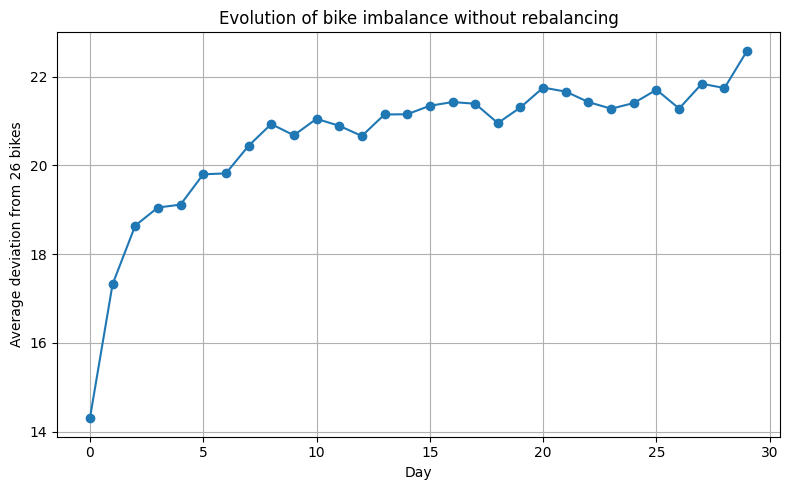

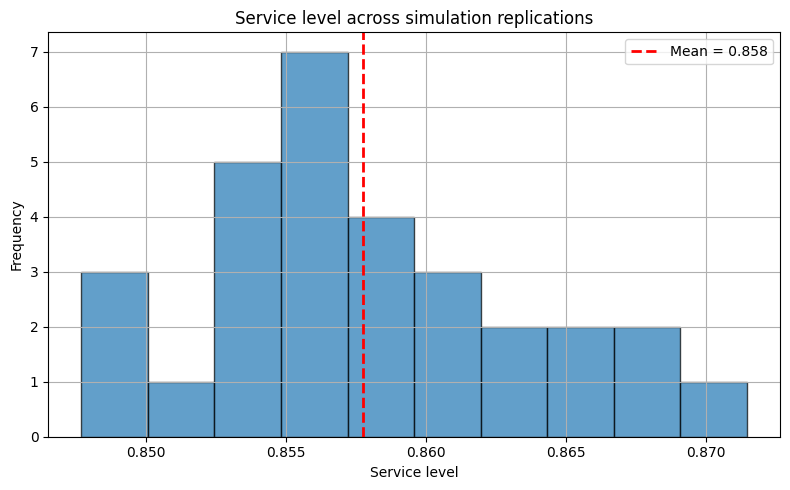

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(mean_daily_imbalance, marker="o")
plt.xlabel("Day")
plt.ylabel("Average deviation from 26 bikes")
plt.title("Evolution of bike imbalance without rebalancing")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
plt.hist(service_levels, bins=10, edgecolor="black", alpha=0.7)
plt.axvline(mean_sl, color="red", linestyle="--", linewidth=2,
            label=f"Mean = {mean_sl:.3f}")
plt.xlabel("Service level")
plt.ylabel("Frequency")
plt.title("Service level across simulation replications")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


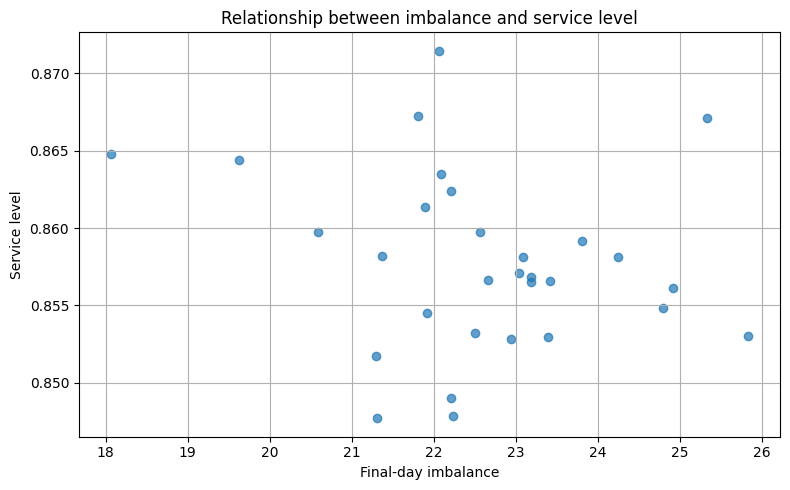

Correlation between imbalance and service level: -0.197


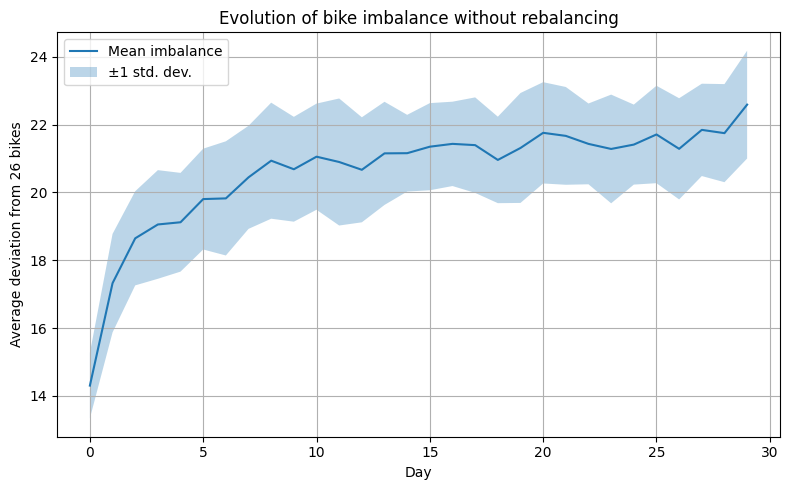

In [48]:

# Use final-day imbalance per replication
final_imbalance = [rep[-1] for rep in all_daily_imbalance]

plt.figure(figsize=(8, 5))
plt.scatter(final_imbalance, service_levels, alpha=0.7)
plt.xlabel("Final-day imbalance")
plt.ylabel("Service level")
plt.title("Relationship between imbalance and service level")
plt.grid(True)
plt.tight_layout()
plt.show()

corr = np.corrcoef(final_imbalance, service_levels)[0, 1]
print(f"Correlation between imbalance and service level: {corr:.3f}")


std_daily_imbalance = np.std(all_daily_imbalance, axis=0)
days = range(len(mean_daily_imbalance))

plt.figure(figsize=(8, 5))
plt.plot(days, mean_daily_imbalance, label="Mean imbalance")
plt.fill_between(
    days,
    mean_daily_imbalance - std_daily_imbalance,
    mean_daily_imbalance + std_daily_imbalance,
    alpha=0.3,
    label="±1 std. dev."
)
plt.xlabel("Day")
plt.ylabel("Average deviation from 26 bikes")
plt.title("Evolution of bike imbalance without rebalancing")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


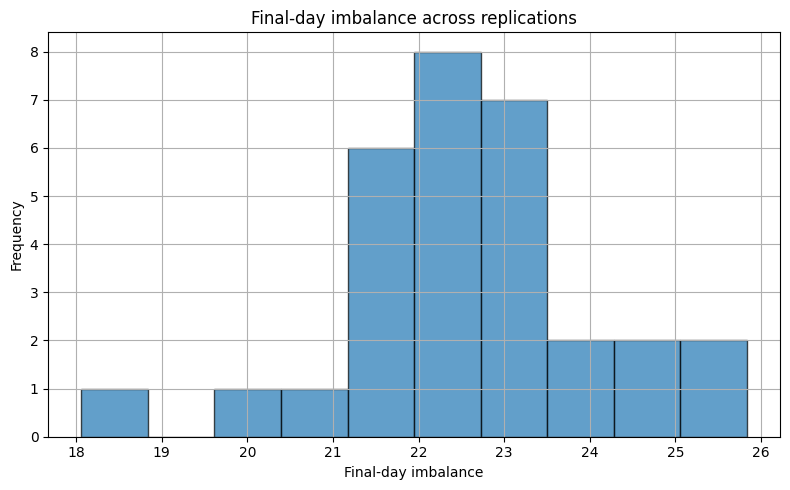

In [49]:
plt.figure(figsize=(8, 5))
plt.hist(final_imbalance, bins=10, edgecolor="black", alpha=0.7)
plt.xlabel("Final-day imbalance")
plt.ylabel("Frequency")
plt.title("Final-day imbalance across replications")
plt.grid(True)
plt.tight_layout()
plt.show()


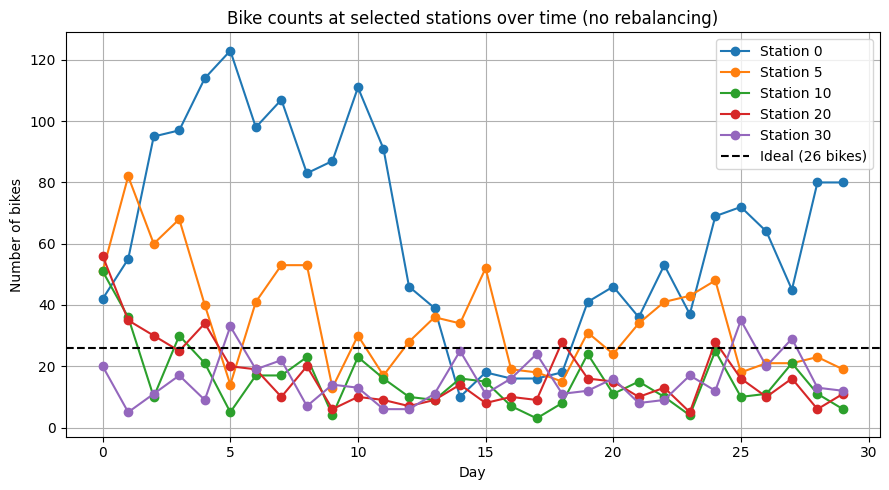

In [60]:
# plotting end of the day bike counts !!!!
stations_to_plot = [0, 5, 10, 20, 30]

plt.figure(figsize=(9, 5))

rep_data = all_daily_bikes[0]

for s in stations_to_plot:
    # Extract bike count of station s for each day
    station_bikes = [day[s] for day in rep_data]
    plt.plot(station_bikes, marker='o', label=f"Station {s}")

plt.axhline(26, linestyle="--", color="black", label="Ideal (26 bikes)")

plt.xlabel("Day")
plt.ylabel("Number of bikes")
plt.title("Bike counts at selected stations over time (no rebalancing)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## PART II: Optimizing rebalancing operations

Having established that some degree of rebalancing may be necessary, your next task is to design efficient strategies to redistribute the 1248 bikes during the night. To gradually build toward your final solution, address the following questions:

1. What would be the ideal starting distribution of bikes at the beginning of the day to maximize the service level? In other words, if there were no constraints on the rebalancing operations, how would you allocate the bikes accross the stations?
2. In practice, the number of bikes that can be moved overnight is limited. Assume that Velocation operates vans, each with a capacity of 30 bikes per night, regardless of the number of pick-up and drop-off locations. How much can the service level be improved by adding one, two, three, or more vans?
3. Using vans is costly, as are multiple stops for pick-up and drop-off operations. For Velocation, the fixed cost to deploy a van is €50 per night. Additionally, each stop at a station (for either pick-up or drop-off) incurs an extra cost of €10. Each van can move at most 30 bikes per night. Your task is to design a rebalancing strategy that achieves an average service level of at least 95% while minimizing the average operational cost per night. Implement this strategy as a function that takes the end-of-day bike distribution (formatted as a list) as input and outputs a matrix indicating, for each element `[i,j]`, the number of bikes transferred from station *i* to station *j* during the night. Use clear visuals to present and interpret your final results.

In [ ]:
# ADD YOUR CODE HERE.

## Grading

When grading, we consider the following:

1.   Does your code run? Is it clear and well-annotated? (10%)
2.   Are your assumptions motivated and reasonable? (20%)
3. How innovative is your optimization approach and how well does it perform? (20%)
4. Do you present your results in a clear, statistically correct, and visually appealing manner? (20%)
5.   Do you correctly interpret and discuss your results? (15%)
6.   Do you manage to present your simulation model well and are able to answer questions related to it (during the presentation)? (15%)
